In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import glob
sys.path.append('../')

from collections import OrderedDict

import numpy as np

from rankutils.stat_mr import StatMR
from rankutils.rIO import read_rank
from rankutils.mappings import exp_aliases
from rankutils.cfgloader import cfgloader

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

from time import time

In [3]:
fwr = StatMR(dist_name='WBL', k=10, method='fixed', opt_metric='MCC', verbose=False)
fwr = StatMR(dist_name='WBL', k=10, method='mixt', opt_metric='MCC', verbose=False)
k = 10

np.set_printoptions(precision=3, suppress=True)

In [4]:
pathcfg = cfgloader("/home/alberto/phD/projects/performance_prediction/ret-mr-learning/source/path_2.cfg")
key_order = ['unicamp_001', 'unicamp_002', 'unicamp_004',
         'places365_001', 'places365_002',
         'imagenet_001', 'imagenet_003', 
         'vggfaces_001', 'vggfaces_002']
            
#key_order = ['oxford_001', 'oxford_002', 'unicamp_001']

table_fwr = OrderedDict()
table_dwr = OrderedDict()

for key in tqdm(key_order, desc='Key ', total=len(key_order)):
    
    rkflist = np.array(glob.glob("{0:s}*.rk".format(pathcfg.get(key, 'rank'))))
    rkflist.sort()
    
    if rkflist.size > 200:
        sample_idx = np.random.choice(np.arange(rkflist.size), 200, replace=False)
        rkflist = rkflist[sample_idx]
    
    table_fwr[key] = np.zeros(len(rkflist), dtype=np.float32) - 1
    table_dwr[key] = np.zeros(len(rkflist), dtype=np.float32) - 1

    for i in tqdm(range(rkflist.size), desc='Rank file ', total=rkflist.size):

        rkfpath = rkflist[i]
        rank = read_rank(rkfpath, colname='score')

        if rank[0] < rank[-1]:
            rank = rank.max() - rank

        data = rank[k:]

        ts = time()
        tau = fwr.statistical_fixed(data, 0.0, 1.0)
        te = time()
        table_fwr[key][i] = te-ts

        ts = time()
        tau = fwr.statistical_mixture(data, 0.0, 1.0)
        te = time()
        table_dwr[key][i] = te-ts

In [5]:

#print(table_fwr['oxford_004'])
#print(table_fwr['oxford_004'].mean())
#print(table_fwr['oxford_004'].std())

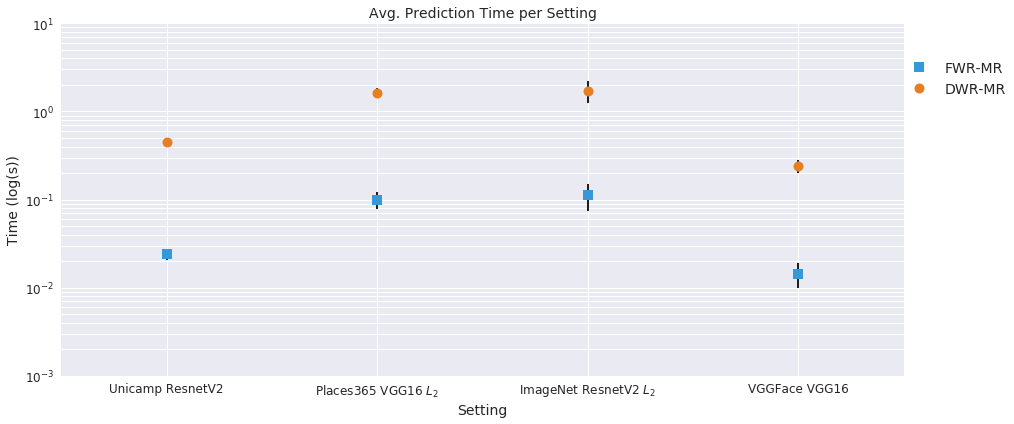

In [46]:
aux = ['unicamp_004',
       'places365_001',
       'imagenet_001', 
       'vggfaces_001',]

fig, axes = plt.subplots(1)
try:
    axes = axes.reshape(-1)
except AttributeError:
    axes = [axes]
fig.set_size_inches((14, 6))

top_lim = -1
bot_lim = np.inf

leg_handles = []
leg_labels = []

x = np.arange(0, len(aux))
y = []
s = []
l = []

for m in aux:
    y.append(table_fwr[m].mean())
    s.append(table_fwr[m].std())
    l.append(exp_aliases[m])

y = np.array(y)
s = np.array(s)

if (y + s).max() > top_lim:
    top_lim = (y + s).max()*1.05
if (y - s).min() < bot_lim:
    bot_lim = (y - s).min()*0.95

ebar = axes[0].errorbar(x, y, yerr=s, xerr=None, capsize=100, ecolor='black', linestyle='', 
                        marker='s', markersize=10, color='#3498db', alpha=1.0)

leg_handles.append(ebar[0])

y = []
s = []

for m in aux:
    y.append(table_dwr[m].mean())
    s.append(table_dwr[m].std())

y = np.array(y)
s = np.array(s)

if (y + s).max() > top_lim:
    top_lim = (y + s).max()*1.05
if (y - s).min() < bot_lim:
    bot_lim = (y - s).min()*0.95

ebar = axes[0].errorbar(x, y, yerr=s, xerr=None, capsize=100, ecolor='black', linestyle='',
                        marker='o', markersize=10, color='#e67e22', alpha=1.0)

leg_handles.append(ebar[0])

#leg_handles = [ebar['FWR-MR'][0], ebar['DWR-MR'][0]]
#leg_labels = ['FWR-MR', 'DWR-MR']

#axes[0].set_ylim(top=(y + s).max()*1.1, bottom=(y - s).min()*0.9)
axes[0].set_ylim(top=10*1, bottom=10**-3)
axes[0].set_xlim(left=x[0] - 0.5, right=x[-1] + 0.5)
axes[0].set_xticks(x)
axes[0].set_xticklabels(l, rotation=0, ha="center", **dict(fontsize=12))

axes[0].set_ylabel('Time (log(s))', **dict(fontsize=14))
axes[0].set_xlabel('Setting', **dict(fontsize=14))
axes[0].set_yticklabels(axes[0].get_yticklabels(), **dict(fontsize=12))

axes[0].set_title('Avg. Prediction Time per Setting', **dict(fontsize=14))


plt.yscale('log', nonposy='clip')
plt.grid(True, which="both")
fig.legend(leg_handles, ['FWR-MR', 'DWR-MR'], fancybox=True, shadow=True, ncol=1,
           fontsize=14, loc='center right', bbox_to_anchor=[1.01, 0.80])
fig.tight_layout()
plt.subplots_adjust(right=0.90)
plt.savefig('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/results/thesis/timing/stat-mr_timing.pdf', dpi=300)